# DS 303 Assignment 2

## Name: Rohan Rajesh Kalbag
### Roll no: 20D170033

# (1) Importing the **CIFAR10** dataset

In [1]:
import tensorflow as tf
# load the CIFAR10 dataset from tensorflow datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [2]:
#printing the shapes of the datasets to see the nature of data
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## To concatenate the default test and train splits

In [3]:
import numpy as np
x_values = np.concatenate([x_train,x_test], axis=0)
y_values = np.concatenate([y_train,y_test], axis=0)
#concatenating all the existing values to resplit again later
print(x_values.shape)
print(y_values.shape)

(60000, 32, 32, 3)
(60000, 1)


## (2) To convert to grayscale

- We are using the [luminosity method](https://en.wikipedia.org/wiki/Grayscale)

In [4]:
'''To matrix multiply X with w where w = [0.229 0.587 0.114] which correspond to grayscale shown
as a linear combination of R G and B'''
x_values = np.dot(x_values, np.array([0.299 , 0.587, 0.114]))
print(x_values.shape)

(60000, 32, 32)


## (3) We perform a 80:20 split. Since the data was already given in a random fashion we just index the data in the ratio 80:20

In [5]:
print(int(0.8*x_values.shape[0]),int(0.2*x_values.shape[0])) # The lengths of train and test for 80:20 split

48000 12000


Splitting the dataset into test and train.

In [6]:
X_train = x_values[:48000,:,:]
print(X_train.shape)
X_test = x_values[48000:,:,:]
print(X_test.shape)
Y_train = y_values[:48000,:]
Y_test = y_values[48000:,:]
print(Y_train.shape)
print(Y_test.shape)

(48000, 32, 32)
(12000, 32, 32)
(48000, 1)
(12000, 1)


## To check if everything till now is perfect
The subsequent code displays the labels and images for the first nine images in X_train

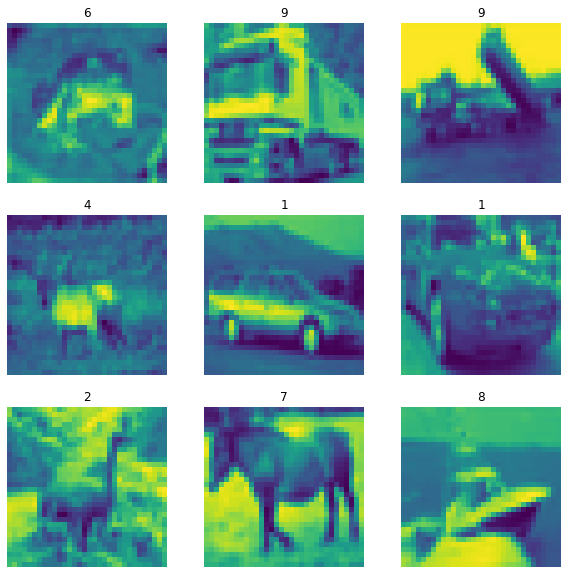

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(Y_train[i][0])
  plt.axis("off")

# (4) Flattening the X features

We reshape the (48000,32,32) arrays into (48000,1024), basically flattening the images into an array of 1024 pixels

In [8]:
X_train_flattened = X_train.reshape((48000,32*32))
print(X_train_flattened.shape)
X_test_flattened = X_test.reshape((12000,32*32))
print(X_test_flattened.shape)

(48000, 1024)
(12000, 1024)


# Splitting the data into classes

We seperate the train data classwise on the basis of the value of y

In [9]:
X_train_classwise = []

for i in range(10):
    X_train_classwise.append(X_train_flattened[(Y_train==i).ravel(),:]) #find all the indices that have Y_train = i
    #partition the set of X_train into its classes
for i in X_train_classwise:
    print(i.shape)

(4803, 1024)
(4798, 1024)
(4813, 1024)
(4786, 1024)
(4828, 1024)
(4802, 1024)
(4796, 1024)
(4799, 1024)
(4785, 1024)
(4790, 1024)


In [10]:
print(Y_train.shape)
print(Y_train.ravel().shape)

(48000, 1)
(48000,)


- We now need to fit each pixel with a Gaussian Mixture Model
- [Gaussian Mixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) class of sklearn (scikit-learn) library was used for this for quick implementation of the EM algorithm
- The parameters used for the class - $\verb|n_components = 2, max_iter=1500|$

$\verb|n_components|$ are two as we fit two Gaussians on the data, $\verb|max_iter|$ denotes the maximum number of times EM algorithm can be applied before which a case is deemed as not convergent. The data such that we see the same result in case execution is paused in the middle for some reason.

In [12]:
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
gms = [] # create a large matrix to hold all the GaussianMixture objects
for i in range(10): #outer loop for each class
    gm = [] #each row of the matrix
    for j in tqdm(range(1024)):
        #in each pass of this loop we take all the values of the particular pixel across the training data and fit it with two gaussians
        k = GaussianMixture(n_components=2,max_iter=1500).fit((X_train_classwise[i][j,:]).reshape(-1,1))
        gm.append(k) #add the object to the row
    gms.append(gm) #add the row to the large matrix

100%|██████████| 1024/1024 [00:21<00:00, 48.75it/s]


### To see the parameters for the Gaussian Mixture Model fitted on the first pixel for the class 0

In [13]:
testgm = gms[0][0] 
print("Weights:",testgm.weights_)
print("Means:",testgm.means_.ravel()) #to display the means
print("Covariances:",testgm.covariances_.ravel())

Weights: [0.54022134 0.45977866]
Means: [227.9883716   55.09992146]
Covariances: [ 376.43116049 1811.23658047]


# (5) and (6)
- Let $w_1,w_2,\mu_1,\mu_2,\sigma_1,\sigma_2$ denote the values obtained in the previous statement.
- The probability $\mathbb{P}$ that a particular pixel $x$ 
belongs to a particular class $y$ is given by
$\mathbb{P}(x \in y) = w_1\cdot f_{\mu_1,\sigma_1}(x) + w_2\cdot f_{\mu_2,\sigma_2}(x)$
- $f_{\mu,\sigma}(\cdot)$ denotes the probability density function for a gaussian random variable

- The probability that an Image is classified as y is $\mathbb{P}(X \in y) = \Pi_{i=1}^{1024}\mathbb{P}(x_i \in y)$
- We assign the class y on the basis of which class has the maximum probability as :  $\hat{y} = argmax_y(\mathbb{P}(X \in y))$
- Since the probabilities are small taking product is very inconvienient hence we take sum of logarithms of the probabilities

In [14]:
from scipy.stats import norm

def logprob(x, gm):
    '''This function takes in the value of the pixel x and the Gaussian Mixture Model for that particular pixel and returns the 
    probability that the pixel belongs to the class y
    '''
    weights = gm.weights_
    means = gm.means_.ravel()
    covariances = gm.covariances_.ravel()
    return np.log(weights[0]*norm.pdf(x,means[0],covariances[0]) + weights[1]*norm.pdf(x,means[1],covariances[1]))

In [15]:
def predict(X):
    '''This function predicts the labels for an input. It takes in the x values for the test data and returns the predicted
    labels for the corresponding x values'''
    y = [] #This contains the y values
    for i in tqdm(range(X.shape[0])):
        log_probs = np.array(range(10)) # This will contain the logprobabilities that the image belongs to a particular class
        for j in range(10):
            log_prob = 0
            for k in range(1024):
                this_gm = gms[j][k] # take the gaussian mixture model corresponding to the jth class and kth pixel
                log_prob += logprob(X[i][k], this_gm) # add the log probability that the kth pixel of the ith image belongs to the jth class
            log_probs[j] = log_prob # store this for the jth class
        y.append(np.argmax(log_probs)) #choose the class which has the maximum logprobability
    return y

# Test accuracy for 1000 samples.
As it takes an average time of 2s per iteration and can take a very long time if the entire dataset of 12000 test images is fed.

In [19]:
from sklearn.metrics import accuracy_score
y_pred = predict(X_test_flattened[:1000])
y_actual = Y_test[:1000]
print(accuracy_score(y_actual,y_pred))

100%|██████████| 1000/1000 [24:27<00:00,  1.47s/it]

0.101


### Thus we see that the model gives an accuracy of $10.1$% for classifying the CIFAR10 dataset